In [1]:
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
import os

import sys
sys.path.append('axionCAMB_and_lin_PS/')
sys.path.append('cosmology/')
sys.path.append('axion_functions/')
sys.path.append('halo_model/')

from axionCAMB_and_lin_PS import axionCAMB_wrapper 
from axionCAMB_and_lin_PS import load_cosmology  
from axionCAMB_and_lin_PS import lin_power_spectrum 
from axionCAMB_and_lin_PS import PS_interpolate 

from halo_model import HMcode_params
from halo_model import PS_nonlin_cold
from halo_model import PS_nonlin_axion
from halo_model import baryons

from axion_functions import axion_params

In [2]:
### Baryons with no axions

start = time.time()

################################################################################
# Set-up experiment parameters
################################################################################

input_file_path = '/Users/cp2091/PhD/KR_ULADM/axionHMcode_Tagn/input_files/input_file.txt'
input_file_path_baryon = '/Users/cp2091/PhD/KR_ULADM/axionHMcode_Tagn/input_files/input_file_AXION_BARYON.txt'

try:
    f = open(input_file_path)
except IOError:
    print("Input file not accessible, pleas check the file path")
finally:
    f.close()
axionCAMB_exe_path = '/Users/cp2091/PhD/KR_ULADM/axionCAMB'
if os.path.exists(axionCAMB_exe_path+'/./camb') == False:
    print("executabel axionCAMB is not in the given directory, pleas check the path")

In [3]:
################################################################################    
# save cosmological parameter in a dictionary 
################################################################################

cosmos_AXION_BARYON = load_cosmology.load_cosmology_input(input_file_path_baryon) 
cosmos_LCDM = load_cosmology.load_LCDM_cosmology_input(input_file_path)

# Check here later for why LCDM not working

################################################################################
# Run axionCAMB on mixed and LCDM cosmology 
################################################################################

print("axionCAMB is running. Computes transfer function for a LCDM cosmology")
axionCAMB_wrapper.axioncamb_params('paramfiles/paramfile_axionCAMB_LCDM.txt', 
                                   cosmos_LCDM, output_root='paramfiles/cosmos_LCDM', print_info = False)
axionCAMB_wrapper.run_axioncamb('paramfiles/paramfile_axionCAMB_LCDM.txt', 
                                axionCAMB_exe_path,
                                cosmos_LCDM, print_info = False)

print("axionCAMB is running. Computes transfer function for a same cosmology but now with baryons cosmology")
axionCAMB_wrapper.axioncamb_params('paramfiles/paramfile_axionCAMB_AXION_BARYON.txt', 
                                   cosmos_AXION_BARYON, output_root='paramfiles/cosmos_AXION_BARYON', print_info = False)
axionCAMB_wrapper.run_axioncamb('paramfiles/paramfile_axionCAMB_AXION_BARYON.txt', 
                                axionCAMB_exe_path,
                                cosmos_AXION_BARYON, print_info = False)

axionCAMB is running. Computes transfer function for a LCDM cosmology


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG


axionCAMB is running. Computes transfer function for a same cosmology but now with baryons cosmology


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG


In [4]:
################################################################################
# Create linear power spectra from axionCAMB tranfer functions 
################################################################################
# lin PS on given k range

power_spec_dic_LCDM = lin_power_spectrum.func_power_spec_dic('paramfiles/cosmos_LCDM_transfer_out.dat', cosmos_LCDM)
power_spec_dic_AXION_BARYON = lin_power_spectrum.func_power_spec_dic('paramfiles/cosmos_AXION_BARYON_transfer_out.dat', cosmos_AXION_BARYON)

#interpolated lin PS for the correct computations of the variance

power_spec_interp_dic_LCDM = lin_power_spectrum.func_power_spec_interp_dic(power_spec_dic_LCDM, cosmos_LCDM)
power_spec_interp_dic_ax_AXION_BARYON = lin_power_spectrum.func_power_spec_interp_dic(power_spec_dic_AXION_BARYON, cosmos_AXION_BARYON)

##################################
##############################################
# Compute parameter related to axions and HMCode2020
################################################################################
print('-' * 50)
M_arr = np.logspace(cosmos_LCDM['M_min'], cosmos_LCDM['M_max'], 100)
print("Calculate axion quantities; cut-off mass, central density scale of axion density profile and axion halo mass.")

axion_param_AXION_BARYON = axion_params.func_axion_param_dic(M_arr, cosmos_AXION_BARYON, power_spec_interp_dic_ax_AXION_BARYON, eta_given=False)

print("Create dictionary with parameters of HMCode2020")

hmcode_params_LCDM = HMcode_params.HMCode_param_dic(cosmos_LCDM, power_spec_interp_dic_LCDM['k'], power_spec_interp_dic_LCDM['cold'])
hmcode_params_AXION_BARYON = HMcode_params.HMCode_param_dic(cosmos_AXION_BARYON, power_spec_interp_dic_ax_AXION_BARYON['k'], power_spec_interp_dic_ax_AXION_BARYON['cold'])

print("computation time upto here: {:.0f} s".format(time.time() -start))

--------------------------------------------------
Calculate axion quantities; cut-off mass, central density scale of axion density profile and axion halo mass.
Create dictionary with parameters of HMCode2020
computation time upto here: 23 s


In [5]:
import importlib
importlib.reload(baryons)

<module 'halo_model.baryons' from '/Users/cp2091/PhD/KR_ULADM/axionHMcode_Tagn/halo_model/baryons.py'>

In [6]:
################################################################################
# Caluclate non-linear power spectrum in LCDM cosmology both DM only and with baryons
################################################################################

print('Caluclate non-linear power spectrum in LCDM cosmology with the halo model')
PS_LCDM_matter_nonlin = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], power_spec_interp_dic_LCDM['k'], power_spec_interp_dic_LCDM['cold'], cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'], cosmos_LCDM['Omega_db_0'],  alpha = False, eta_given = False, one_halo_damping = True, two_halo_damping = False, Tagn=None)

print('Caluclate non-linear power spectrum in LCDM cosmology with the halo model - now including baryons via Tagn parameter')
T_agn = np.power(10, 7.6)
PS_LCDM_matter_nonlin_baryons = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], power_spec_interp_dic_LCDM['k'], power_spec_interp_dic_LCDM['cold'], cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'], cosmos_LCDM['Omega_db_0'],  alpha = False, eta_given = False, one_halo_damping = True, two_halo_damping = False, Tagn=T_agn)
################################################################################
# Save both power spectra in files
################################################################################


print("Save the non-linear power spectra in a file in the folowing order:")
print("k [h/Mpc], non-lin total matter PS in LCDM [(Mpc/h)^3] and non-lin total matter PS with baryons in LCDM [(Mpc/h)^3]")
data_ax = np.column_stack([power_spec_dic_LCDM['k'], PS_LCDM_matter_nonlin[0], PS_LCDM_matter_nonlin_baryons[0]] )

datafile_path = "output/nonlin_PS_CDMO_CDMBARYONS.txt" #change path if you want
np.savetxt(datafile_path , data_ax)

Caluclate non-linear power spectrum in LCDM cosmology with the halo model
shape of dens_profile_kspace (100, 88)
k_star 0.06848508537226952
shape of dens_profile_kspace (1, 88)
Caluclate non-linear power spectrum in LCDM cosmology with the halo model - now including baryons via Tagn parameter
shape of dens_profile_kspace (100, 88)
shape of dens_profile_kspace (1, 88)
Save the non-linear power spectra in a file in the folowing order:
k [h/Mpc], non-lin total matter PS in LCDM [(Mpc/h)^3] and non-lin total matter PS with baryons in LCDM [(Mpc/h)^3]


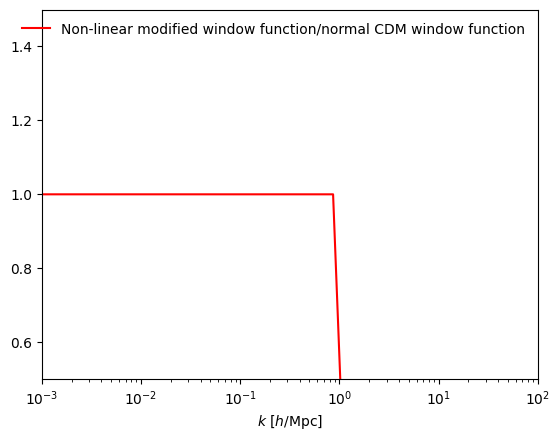

In [9]:
plt.plot(power_spec_dic_LCDM['k'], PS_LCDM_matter_nonlin_baryons[0]/PS_LCDM_matter_nonlin[0], label='Non-linear modified window function/normal CDM window function', color='r')
#plt.plot(power_spec_dic_LCDM['k'], PS_LCDM_matter_nonlin[0], label='Non-linear CDMO', color='blue')

#print( PS_LCDM_matter_nonlin_baryons[0]/PS_LCDM_matter_nonlin[0])
plt.xscale('log')
#plt.yscale('log')
plt.legend(frameon=False)
plt.ylim([0.5,1.5])
plt.xlim([10**(-3),100])
plt.xlabel(r'$k~[h/\mathrm{Mpc}]$')
plt.savefig('ratio_trial.pdf')
plt.show()

(0.001, 100)

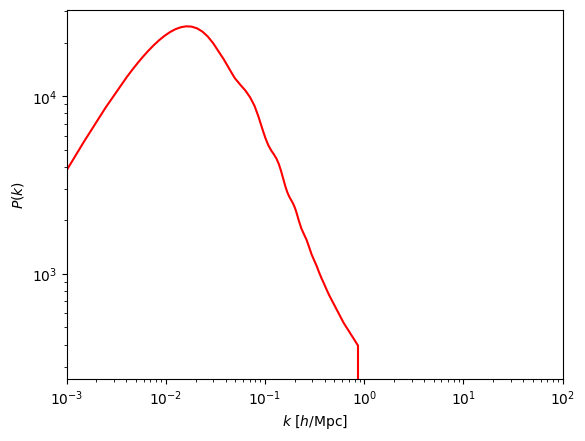

In [10]:
plt.plot(power_spec_dic_LCDM['k'], PS_LCDM_matter_nonlin_baryons[0], label='non-linear ratio baryons', color='r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k~[h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)$')

plt.xlim([10**(-3),100])

